In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cadi-ai/Data/val/val/labels/DIJ1606.txt
/kaggle/input/cadi-ai/Data/val/val/labels/992.txt
/kaggle/input/cadi-ai/Data/val/val/labels/3851.txt
/kaggle/input/cadi-ai/Data/val/val/labels/DIJ1467.txt
/kaggle/input/cadi-ai/Data/val/val/labels/1025.txt
/kaggle/input/cadi-ai/Data/val/val/labels/2460.txt
/kaggle/input/cadi-ai/Data/val/val/labels/788.txt
/kaggle/input/cadi-ai/Data/val/val/labels/DIJ300.txt
/kaggle/input/cadi-ai/Data/val/val/labels/372.txt
/kaggle/input/cadi-ai/Data/val/val/labels/244.txt
/kaggle/input/cadi-ai/Data/val/val/labels/DIJ562.txt
/kaggle/input/cadi-ai/Data/val/val/labels/175.txt
/kaggle/input/cadi-ai/Data/val/val/labels/2214.txt
/kaggle/input/cadi-ai/Data/val/val/labels/1181.txt
/kaggle/input/cadi-ai/Data/val/val/labels/1262.txt
/kaggle/input/cadi-ai/Data/val/val/labels/DIJ385.txt
/kaggle/input/cadi-ai/Data/val/val/labels/2553.txt
/kaggle/input/cadi-ai/Data/val/val/labels/3429.txt
/kaggle/input/cadi-ai/Data/val/val/labels/3886.txt
/kaggle/input/cadi-ai/Da

In [2]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karaagroaiprojects/cadi-ai")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cadi-ai


In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from shutil import copy2
import tqdm
import torch

In [5]:
base_dir = "/kaggle/input/cadi-ai/Data"

# Define paths for training, validation, and testing datasets
train_dir = os.path.join(base_dir, "train/train")
val_dir = os.path.join(base_dir, "val/val")
test_dir = os.path.join(base_dir, "test/test")

In [6]:
def explore_dataset(dataset_dir):
    images_dir = os.path.join(dataset_dir, "images")
    labels_dir = os.path.join(dataset_dir, "labels")
    
    num_images = len(os.listdir(images_dir))
    num_labels = len(os.listdir(labels_dir))
    
    print(f"Dataset: {dataset_dir}")
    print(f"  Number of images: {num_images}")
    print(f"  Number of labels: {num_labels}\n")

print("Exploring dataset structure...")
explore_dataset(train_dir)
explore_dataset(val_dir)
explore_dataset(test_dir)

Exploring dataset structure...
Dataset: /kaggle/input/cadi-ai/Data/train/train
  Number of images: 3788
  Number of labels: 3788

Dataset: /kaggle/input/cadi-ai/Data/val/val
  Number of images: 710
  Number of labels: 710

Dataset: /kaggle/input/cadi-ai/Data/test/test
  Number of images: 238
  Number of labels: 238



Visualizing a sample image with bounding boxes...


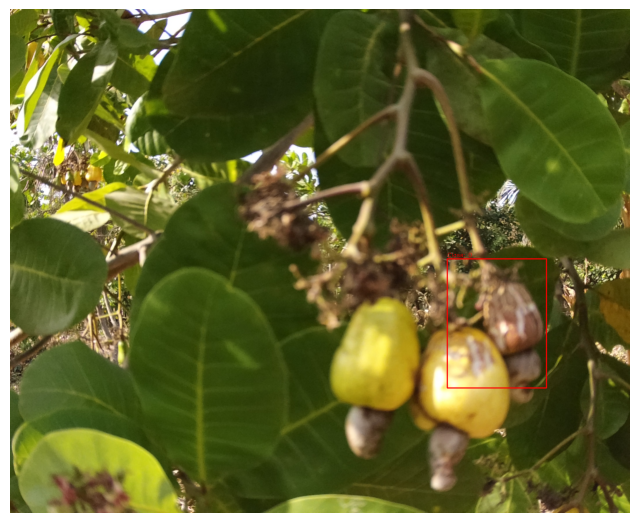

In [7]:
def plot_image_with_boxes(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    with open(label_path, 'r') as f:
        labels = f.readlines()
    
    for label in labels:
        class_id, x_center, y_center, width, height = map(float, label.split())
        img_h, img_w = img.shape[:2]
        x1 = int((x_center - width / 2) * img_w)
        y1 = int((y_center - height / 2) * img_h)
        x2 = int((x_center + width / 2) * img_w)
        y2 = int((y_center + height / 2) * img_h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"Class: {int(class_id)}", (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

sample_image = glob(os.path.join(train_dir, "images", "*.jpg"))[0]
sample_label = sample_image.replace("images", "labels").replace(".jpg", ".txt")
print("Visualizing a sample image with bounding boxes...")
plot_image_with_boxes(sample_image, sample_label)

In [10]:
rm -rf ~/.cache/torch/hub/ultralytics_yolov5_master

In [31]:
!pip uninstall ultralytics -y

Found existing installation: ultralytics 8.3.46
Uninstalling ultralytics-8.3.46:
  Successfully uninstalled ultralytics-8.3.46


In [32]:
!pip install ultralytics==8.0.43

  Using cached ultralytics-8.0.43-py3-none-any.whl.metadata (24 kB)
Using cached ultralytics-8.0.43-py3-none-any.whl (299 kB)


In [34]:
!python -c "import ultralytics; print(ultralytics.__version__)"


8.0.43


In [35]:
!pip install -U ultralytics

  Using cached ultralytics-8.3.46-py3-none-any.whl.metadata (35 kB)
Using cached ultralytics-8.3.46-py3-none-any.whl (898 kB)
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.0.43
    Uninstalling ultralytics-8.0.43:
      Successfully uninstalled ultralytics-8.0.43


In [16]:
# Directories
image_dir = os.path.join(train_dir, "images")
output_dir = "/kaggle/working/filtered/images"
os.makedirs(output_dir, exist_ok=True)

# Function to detect blur
def is_blurry(image_path, threshold=100):
    """Detects if an image is blurry based on the variance of the Laplacian."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    variance = cv2.Laplacian(image, cv2.CV_64F).var()
    return variance < threshold

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Filter images
for img_path in glob(os.path.join(image_dir, "*.jpg")):
    if is_blurry(img_path):
        print(f"Skipping blurry image: {img_path}")
        continue
    
    # Use the updated autocast syntax
    with torch.amp.autocast('cuda'):  # Updated syntax
        results = model(img_path)

    detections = results.pred[0]

    # Check if any detected object is a human (class 0 in YOLOv5)
    has_human = any(int(det[-1]) == 0 for det in detections)
    if has_human:
        print(f"Skipping image with human figures: {img_path}")
        continue
    
    # Save the filtered image to the output directory
    cv2.imwrite(os.path.join(output_dir, os.path.basename(img_path)), cv2.imread(img_path))

print("Image preprocessing completed!")


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-12-7 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

100%|██████████| 14.1M/14.1M [00:00<00:00, 140MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/3532.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/355.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/3574.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2363.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2486.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2087.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2655.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/359.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2642.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2616.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2376.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2488.jpg
Skipping image wit

In [17]:
# Directories for images and annotations
image_dir = os.path.join(train_dir, "images")
label_dir = os.path.join(train_dir, "labels")

# Directories for filtered outputs
filtered_image_dir = "/kaggle/working/filtered/images"
filtered_label_dir = "/kaggle/working/filtered/labels"
os.makedirs(filtered_image_dir, exist_ok=True)
os.makedirs(filtered_label_dir, exist_ok=True)

model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

# Function to process and filter
for img_path in glob(os.path.join(image_dir, "*.jpg")):
    # Check if the image is blurry
    if is_blurry(img_path):
        print(f"Skipping blurry image: {img_path}")
        continue

    # Run YOLO model to detect objects
    results = model(img_path)
    detections = results.pred[0]
    
    # Skip images with humans detected
    has_human = any(int(det[-1]) == 0 for det in detections)  # Assuming COCO class 0 = human
    if has_human:
        print(f"Skipping image with human figures: {img_path}")
        continue

    # Save the filtered image
    filtered_img_path = os.path.join(filtered_image_dir, os.path.basename(img_path))
    cv2.imwrite(filtered_img_path, cv2.imread(img_path))
    
    # Save corresponding annotation
    label_path = os.path.join(label_dir, os.path.basename(img_path).replace(".jpg", ".txt"))
    filtered_label_path = os.path.join(filtered_label_dir, os.path.basename(label_path))
    
    if os.path.exists(label_path):
        copy2(label_path, filtered_label_path)

print("Filtered images and annotations saved successfully!")

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-7 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/3532.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/355.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/3574.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2363.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2486.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2087.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2655.jpg
Skipping image with human figures: /kaggle/input/cadi-ai/Data/train/train/images/359.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2642.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2616.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2376.jpg
Skipping blurry image: /kaggle/input/cadi-ai/Data/train/train/images/2488.jpg
Skipping image wit

In [18]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 27 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.69 MiB | 27.84 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/kaggle/working/yolov5


In [20]:
# Path to common.py
common_py_path = '/kaggle/working/yolov5/models/common.py'

# Define the new classes
new_code = """
import torch
import torch.nn as nn

# Transformer Layer for self-attention
class TransformerLayer(nn.Module):
    def __init__(self, c, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(c)
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.ma = nn.MultiheadAttention(embed_dim=c, num_heads=num_heads)
        self.ln2 = nn.LayerNorm(c)
        self.fc1 = nn.Linear(c, c, bias=False)
        self.fc2 = nn.Linear(c, c, bias=False)

    def forward(self, x):
        x_ = self.ln1(x)
        x = self.ma(self.q(x_), self.k(x_), self.v(x_))[0] + x
        x = self.ln2(x)
        x = self.fc2(self.fc1(x)) + x
        return x

# Transformer Block containing multiple transformer layers
class TransformerBlock(nn.Module):
    def __init__(self, c1, c2, num_heads, num_layers):
        super().__init__()
        self.conv = Conv(c1, c2) if c1 != c2 else None
        self.linear = nn.Linear(c2, c2)
        self.tr = nn.Sequential(*[TransformerLayer(c2, num_heads) for _ in range(num_layers)])
        self.c2 = c2

    def forward(self, x):
        if self.conv is not None:
            x = self.conv(x)
        b, _, w, h = x.shape
        p = x.flatten(2)
        p = p.unsqueeze(0)
        p = p.transpose(0, 3)
        p = p.squeeze(3)
        e = self.linear(p)
        x = p + e

        x = self.tr(x)
        x = x.unsqueeze(3)
        x = x.transpose(0, 3)
        x = x.reshape(b, self.c2, w, h)
        return x

# Transformer-based C3 Module
class C3TR(C3):
    def __init__(self, c1, c2, n=1, shortcut=True, g=1, e=0.5):
        super().__init__(c1, c2, n, shortcut, g, e)
        c_ = int(c2 * e)
        self.m = TransformerBlock(c_, c_, 4, n)

# Residual Block for skip connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.residual = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        residual = self.residual(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return self.relu(x + residual)
"""

# Append the new code to common.py
with open(common_py_path, 'a') as f:
    f.write(new_code)

print("Custom layers added to common.py!")

Custom layers added to common.py!


In [21]:
!tail -n 80 /kaggle/working/yolov5/models/common.py

        x = self.conv2(x)
        x = self.bn2(x)
        return self.relu(x + residual)

import torch
import torch.nn as nn

# Transformer Layer for self-attention
class TransformerLayer(nn.Module):
    def __init__(self, c, num_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(c)
        self.q = nn.Linear(c, c, bias=False)
        self.k = nn.Linear(c, c, bias=False)
        self.v = nn.Linear(c, c, bias=False)
        self.ma = nn.MultiheadAttention(embed_dim=c, num_heads=num_heads)
        self.ln2 = nn.LayerNorm(c)
        self.fc1 = nn.Linear(c, c, bias=False)
        self.fc2 = nn.Linear(c, c, bias=False)

    def forward(self, x):
        x_ = self.ln1(x)
        x = self.ma(self.q(x_), self.k(x_), self.v(x_))[0] + x
        x = self.ln2(x)
        x = self.fc2(self.fc1(x)) + x
        return x

# Transformer Block containing multiple transformer layers
class TransformerBlock(nn.Module):
    def __init__(self, c1, c2, num_heads, num_layers):
        super().__

In [22]:
# Path to yolov5s.yaml
yolov5s_yaml_path = '/kaggle/working/yolov5/models/yolov5s.yaml'

# Define the updated YAML content
new_yaml_content = """
# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 3  # Number of classes for CADI AI dataset
depth_multiple: 0.33  # Model depth multiple
width_multiple: 0.50  # Layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],  # Replace with C3TR for Transformer Block if needed
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3TR, [256]],  # Use Transformer-enhanced C3
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],  # Retain standard C3 for deeper layers
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],  # Reduce channels
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # Concat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # Concat backbone P3
   [-1, 3, C3, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # Concat head P4
   [-1, 3, C3, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # Concat head P5
   [-1, 3, C3, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

"""

# Write the new content to yolov5s.yaml
with open(yolov5s_yaml_path, 'w') as f:
    f.write(new_yaml_content)

print("Updated yolov5s.yaml successfully!")

Updated yolov5s.yaml successfully!


In [23]:
!cat /kaggle/working/yolov5/models/yolov5s.yaml


# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 3  # Number of classes for CADI AI dataset
depth_multiple: 0.33  # Model depth multiple
width_multiple: 0.50  # Layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],  # Replace with C3TR for Transformer Block if needed
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3TR, [256]],  # Use Transformer-enhanced C3
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],  # Retain standard C3 for deeper layers
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],  # Reduce channels
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # Conc

In [24]:
filtered_image_count = len(glob(os.path.join("/kaggle/working/filtered/images", "*.*")))
filtered_label_count = len(glob(os.path.join("/kaggle/working/filtered/labels", "*.txt")))

print(f"Number of filtered images : {filtered_image_count}")
print(f"Number of filtered labels : {filtered_label_count}")

Number of filtered images : 2664
Number of filtered labels : 2664


In [25]:
# Python code to create data.yaml file

yaml_content = """
# data.yaml for CADI AI - Cashew Disease Identification
train: /kaggle/working/filtered/images
val: /kaggle/input/cadi-ai/Data/val/val/images
test: /kaggle/input/cadi-ai/Data/test/test/images

nc: 3
names: ['Disease', 'Abiotic', 'Insect']
"""

# Path where you want to save the data.yaml file
yaml_file_path = '/kaggle/working/yolov5/data.yaml'

# Write the content to the file
with open(yaml_file_path, 'w') as file:
    file.write(yaml_content)

print(f"data.yaml file has been created at {yaml_file_path}")

data.yaml file has been created at /kaggle/working/yolov5/data.yaml


In [26]:
import torch
if torch.cuda.is_available():
    print("GPU is available.")
else:
    print("GPU is not available. Training will fall back to CPU.")

GPU is available.


In [37]:
pip install git+https://github.com/ultralytics/ultralytics.git

  Cloning https://github.com/ultralytics/ultralytics.git to /tmp/pip-req-build-hrbd8eo3
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-hrbd8eo3
  Resolved https://github.com/ultralytics/ultralytics.git to commit 95a9796fee5a110fdd861e12b476b1dfa237b910
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for ultralytics: filename=ultralytics-8.3.44-py3-none-any.whl size=898706 sha256=5129d904afe79b05dad5bd2055323982d6a56bb193f48d193a606d3d01c23ad5
  Stored in directory: /tmp/pip-ephem-wheel-cache-kb0u5bn3/wheels/45/25/b9/9f1e3857f58c296e7854ef871c3f5a15d519cc6c679848df8e
Successfully built ultralytics
  Attempting uninstall: ultralytics
    Found existing installation: ultralytics 8.3.46
    Uninstalling ultralytics-8.3.46:
      Successfully uninstalled ultralytics-8.3.46
Note: you may need to restart the kernel to 

In [38]:
!python /kaggle/working/yolov5/train.py --img 512 --batch 8 --epochs 10 --data /kaggle/working/yolov5/data.yaml --cfg /kaggle/working/yolov5/models/yolov5s.yaml --weights yolov5s.pt --device 0 --patience 5

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=/kaggle/working/yolov5/models/yolov5s.yaml, data=/kaggle/working/yolov5/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=10, batch_size=8, imgsz=512, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr

In [53]:
%reload_ext tensorboard
%tensorboard --logdir runs

Reusing TensorBoard on port 6006 (pid 441), started 0:25:17 ago. (Use '!kill 441' to kill it.)

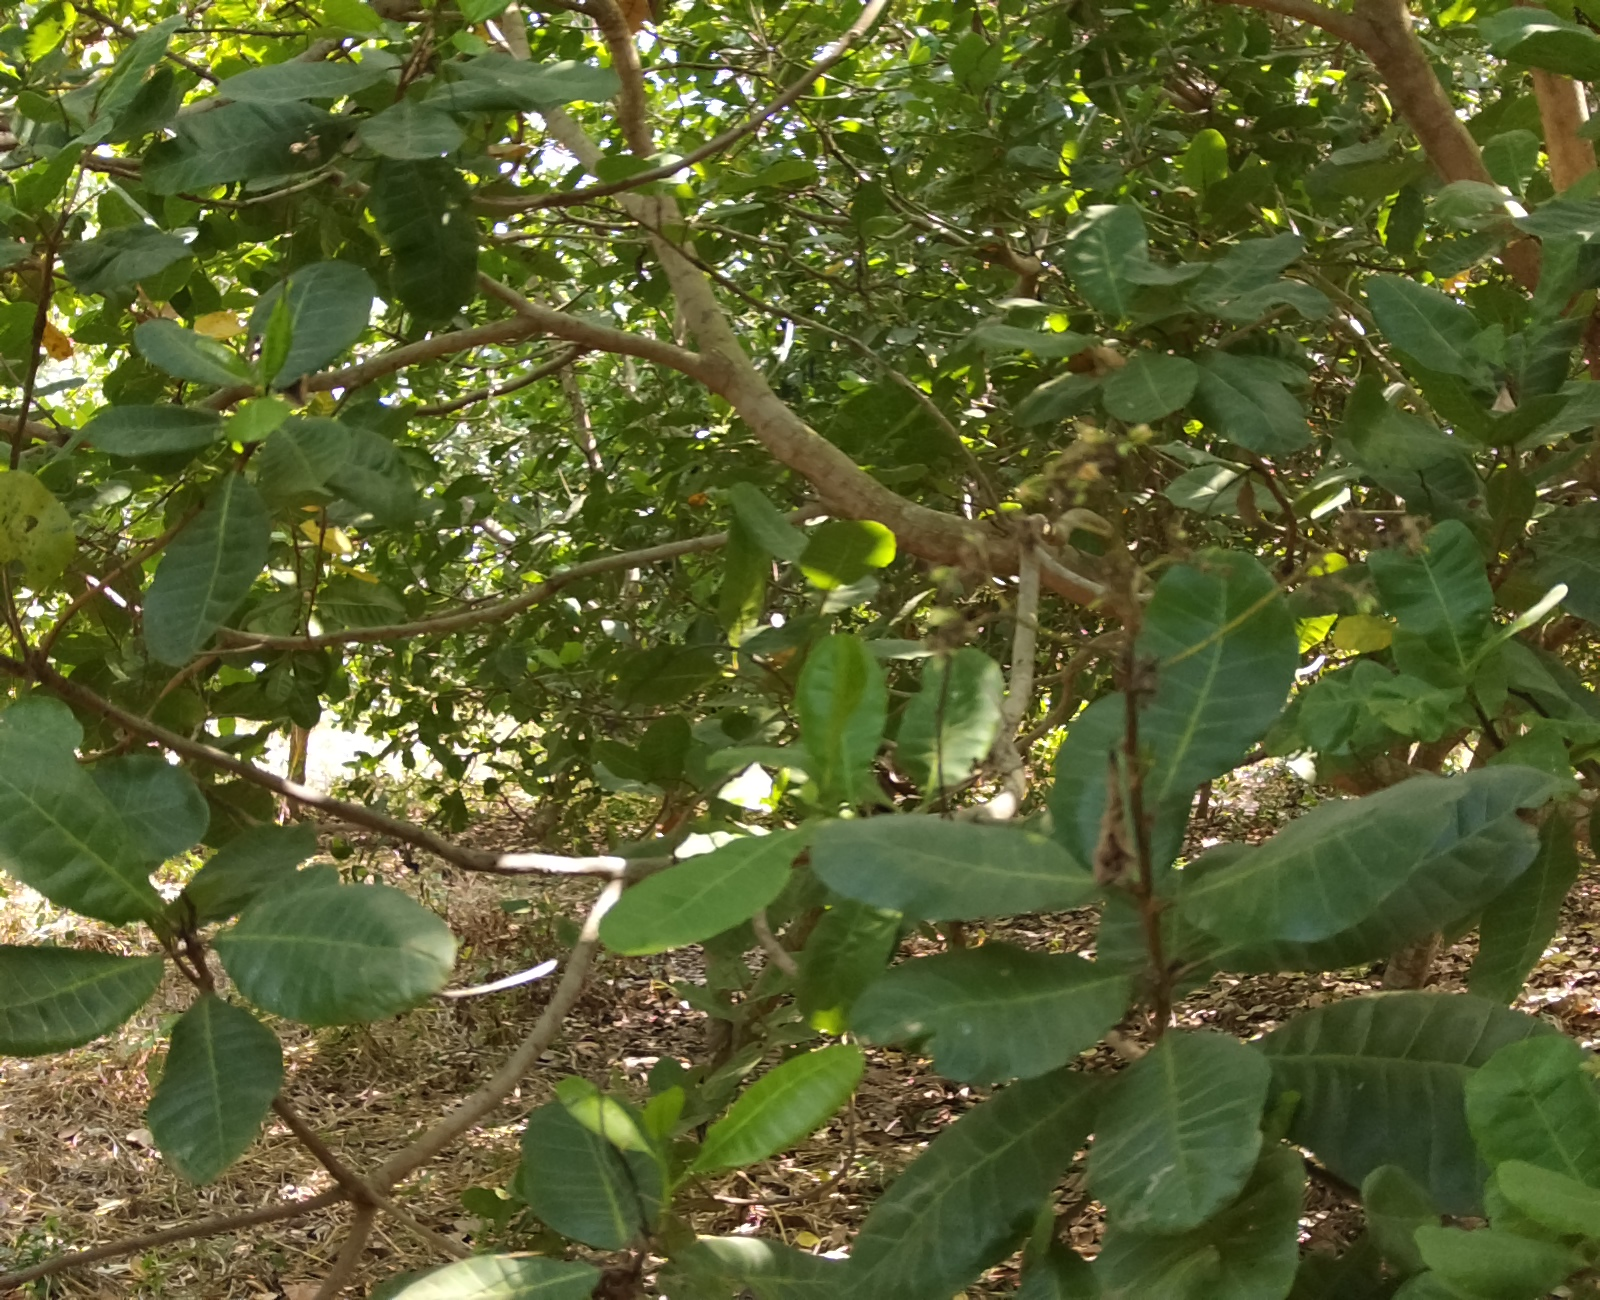

In [41]:
from IPython.display import Image
Image(filename = '/kaggle/input/cadi-ai/Data/test/test/images/1040.jpg', width = 416)

In [44]:
!python detect.py --source /kaggle/input/cadi-ai/Data/test/test/images/1040.jpg --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/cadi-ai/Data/test/test/images/1040.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 169 layers, 7014952 parameters, 0 gradients, 15.3 GFLOPs
image 1/1 /kaggle/input/cadi-ai/Data/test/test/images/1040.jpg: 544x640 1 Abiotic, 56.6ms
Speed: 0.7ms pre-process, 56.6ms inference, 154.0ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp2


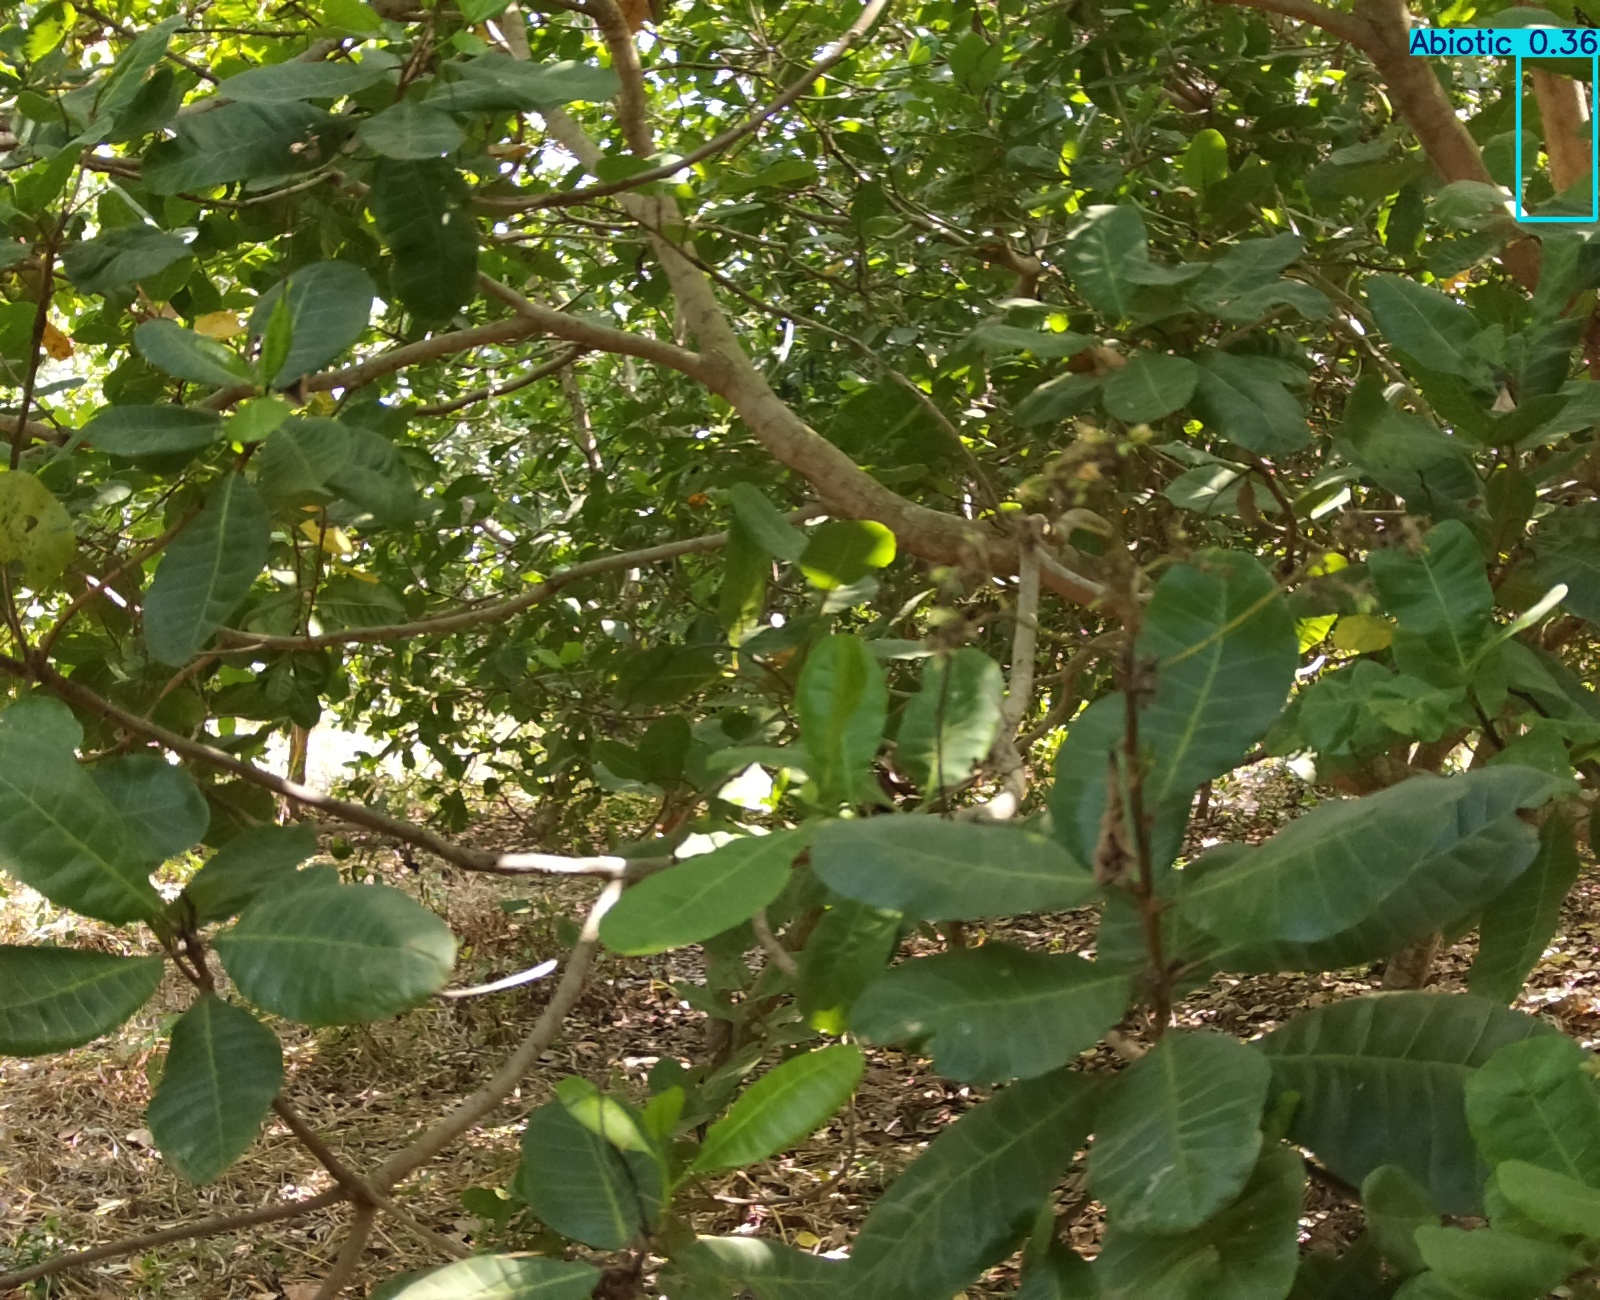

In [45]:
Image(filename = 'runs/detect/exp2/1040.jpg', width = 416)

In [47]:
!python detect.py \
  --source /kaggle/input/cadi-ai/Data/test/test/images \
  --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt \
  --img-size 640 \
  --conf-thres 0.25 \
  --iou-thres 0.45 \
  --save-txt \
  --save-conf

detect: weights=['/kaggle/working/yolov5/runs/train/exp/weights/best.pt'], source=/kaggle/input/cadi-ai/Data/test/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=True, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 169 layers, 7014952 parameters, 0 gradients, 15.3 GFLOPs
image 1/238 /kaggle/input/cadi-ai/Data/test/test/images/1004.jpg: 544x640 3 Abiotics, 56.5ms
image 2/238 /kaggle/input/cadi-ai/Data/test/test/images/1026.jpg: 544x640 3 Abiotics, 1 Insect, 51.7ms
image 3/238 /kaggle/input/cadi-ai/Data/test/test/images/1040.jpg: 544x640 1 A

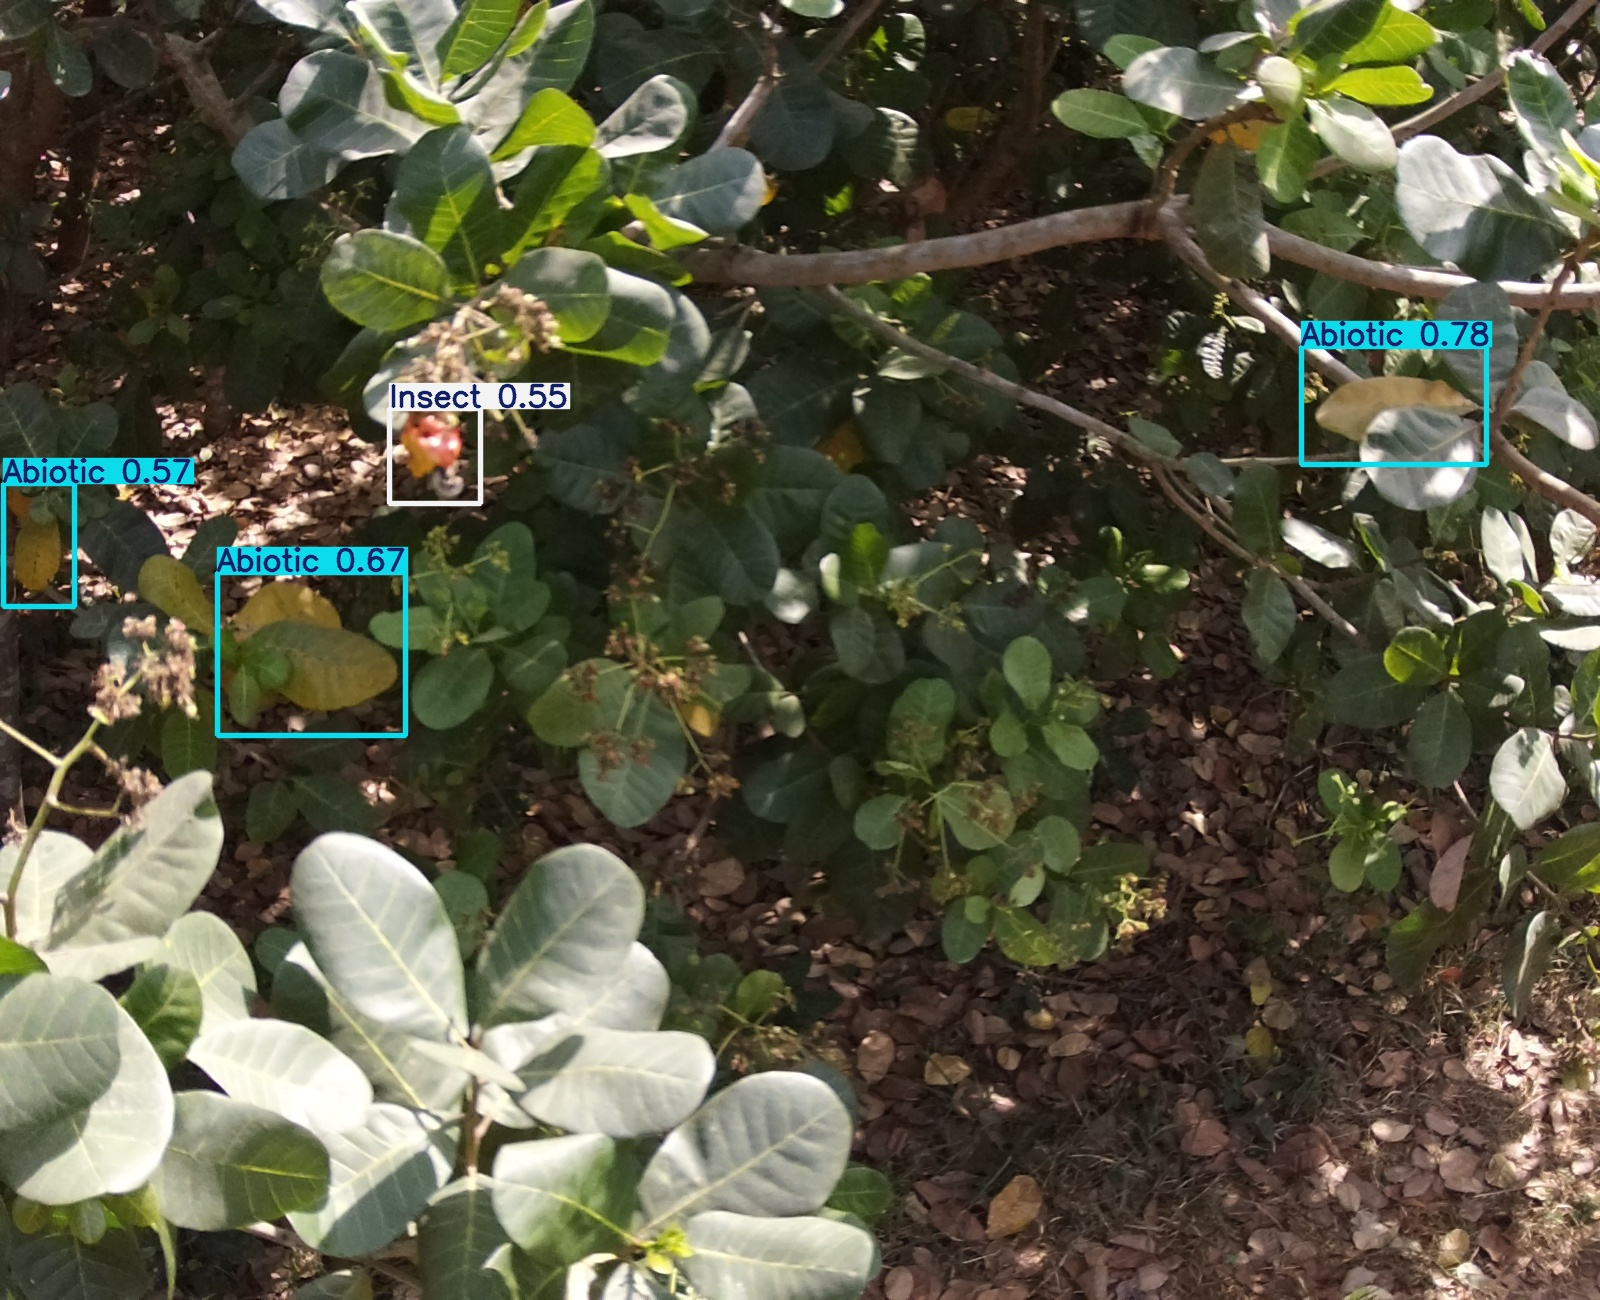

In [48]:
Image(filename = '/kaggle/working/yolov5/runs/detect/exp4/1153.jpg', width = 416)

In [ ]:
# !python val.py \
#   --weights /kaggle/working/yolov5/runs/train/exp/weights/best.pt \
#   --data /kaggle/working/yolov5/data.yaml \
#   --img-size 640 \
#   --task test

In [87]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=9804473a08074bcb7e6a35d9518e91729d81c411961ba4f5c9906f498f87ffb9
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [100]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torch    
import cv2
import numpy as np
import torchvision.transforms as transforms
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import matplotlib.pyplot as plt

# Define random colors for bounding boxes
COLORS = np.random.uniform(0, 255, size=(80, 3))

def parse_detections(results):
    detections = results.pandas().xyxy[0]
    detections = detections.to_dict()
    boxes, colors, names = [], [], []

    for i in range(len(detections["xmin"])):
        confidence = detections["confidence"][i]
        if confidence < 0.2:
            continue
        xmin = int(detections["xmin"][i])
        ymin = int(detections["ymin"][i])
        xmax = int(detections["xmax"][i])
        ymax = int(detections["ymax"][i])
        name = detections["name"][i]
        category = int(detections["class"][i])
        color = COLORS[category]

        boxes.append((xmin, ymin, xmax, ymax))
        colors.append(color)
        names.append(name)
    return boxes, colors, names


def draw_detections(boxes, colors, names, img):
    for box, color, name in zip(boxes, colors, names):
        xmin, ymin, xmax, ymax = box
        cv2.rectangle(
            img,
            (xmin, ymin),
            (xmax, ymax),
            color, 
            2)

        cv2.putText(img, name, (xmin, ymin - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return img


# Local path for the image
image_path = '/kaggle/input/cadi-ai/Data/test/test/images/1040.jpg'
img = np.array(Image.open(image_path))  # Open the image directly
img = cv2.resize(img, (640, 640))  # Resize image for YOLOv5 input
rgb_img = img.copy()
img = np.float32(img) / 255  # Normalize the image
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

# Load pre-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.eval()
model.cpu()

# Define the target layer (the penultimate layer of YOLOv5)
target_layers = [model.model.model.model[-2]]

# Apply the model to the image
results = model([rgb_img])
boxes, colors, names = parse_detections(results)
detections = draw_detections(boxes, colors, names, rgb_img.copy())
Image.fromarray(detections)

# Initialize Eigen-CAM
eigen_cam = EigenCAM(model, target_layers=target_layers)

# Generate CAM
with torch.no_grad():
    model.eval()
    rgb_tensor = tensor.cpu()  # Ensure it's on CPU for display
    cam = eigen_cam(input_tensor=rgb_tensor, targets=None)  # Generate CAM

    # Since cam is a numpy array, directly access the first element
    cam_image = cam[0]  # Extract the CAM for the first image

# Ensure the image is in the range [0, 1] and of type np.float32
rgb_img = np.float32(rgb_img) / 255.0  # Normalize the image to [0, 1]

# Normalize the CAM image
cam_image = scale_cam_image(cam_image)

# Overlay the CAM on the original image
overlayed_img = show_cam_on_image(rgb_img, cam_image, use_rgb=True)

# Check the shape of the final overlayed image to ensure it's RGB and valid
print(f"Shape of the overlayed image: {overlayed_img.shape}")

# Display the result using Matplotlib
plt.figure(figsize=(10, 10))

# Ensure that the image is in the correct format (RGB)
plt.imshow(overlayed_img)
plt.axis('off')  # Hide axes for cleaner display
plt.title("Eigen-CAM on YOLOv5 Detection")
plt.show()

# Optionally, check if the image looks correct by saving it
# cv2.imwrite('cam_overlay.png', overlayed_img)


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-12-7 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Shape of the overlayed image: (640, 640, 3)


In [104]:
import cv2
import numpy as np
from PIL import Image

# Convert BGR to RGB if necessary (as OpenCV uses BGR by default)
overlayed_img = cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB)

# Show the image
Image.fromarray(overlayed_img).show()  # This will open the image in a default viewer

# Save the image as a PNG file
output_path = '/kaggle/working/cam_overlay.png'  # Specify the output path and filename
cv2.imwrite(output_path, cv2.cvtColor(overlayed_img, cv2.COLOR_RGB2BGR))  # Convert back to BGR for OpenCV
print(f"Image saved as {output_path}")


Image saved as /kaggle/working/cam_overlay.png


/usr/bin/xdg-open: 882: www-browser: not found
/usr/bin/xdg-open: 882: links2: not found
/usr/bin/xdg-open: 882: elinks: not found
/usr/bin/xdg-open: 882: links: not found
/usr/bin/xdg-open: 882: lynx: not found
/usr/bin/xdg-open: 882: w3m: not found
xdg-open: no method available for opening '/tmp/tmplcxv824a.PNG'
